Combined Students and Grades Data
   first_name last_name  subject  grade
0       Alice   Johnson     Math     79
1       Alice   Johnson  English    104
2       Alice   Johnson  History     74
3       Alice   Johnson  Science    101
4         Bob     Smith     Math     78
5         Bob     Smith  English    105
6         Bob     Smith  History     73
7         Bob     Smith  Science    102
8       Carol     White     Math     77
9       Carol     White  English    106
10      Carol     White  History     72
11      Carol     White  Science    103
12      David     Brown     Math     76
13      David     Brown  English    107
14      David     Brown  History     71
15      David     Brown  Science    104
16        Eve     Davis     Math     75
17        Eve     Davis  English    108
18        Eve     Davis  History     70
19        Eve     Davis  Science    105


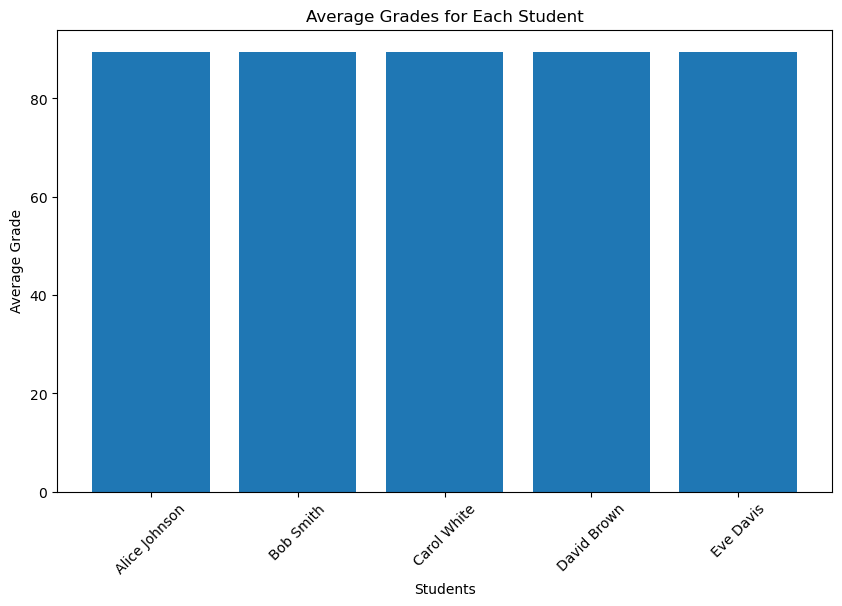

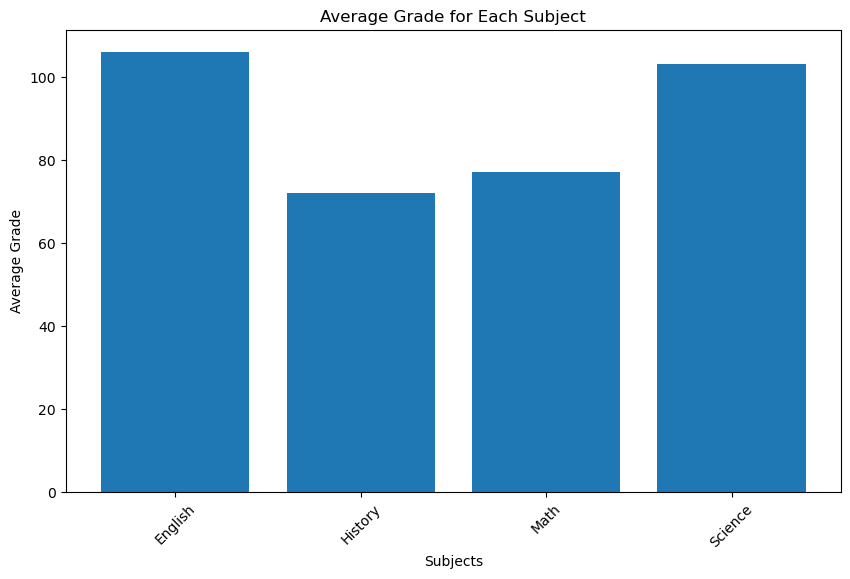

Student with the highest grade in each subject:
Alice Johnson - Math: 79
Alice Johnson - History: 74
Eve Davis - English: 108
Eve Davis - Science: 105


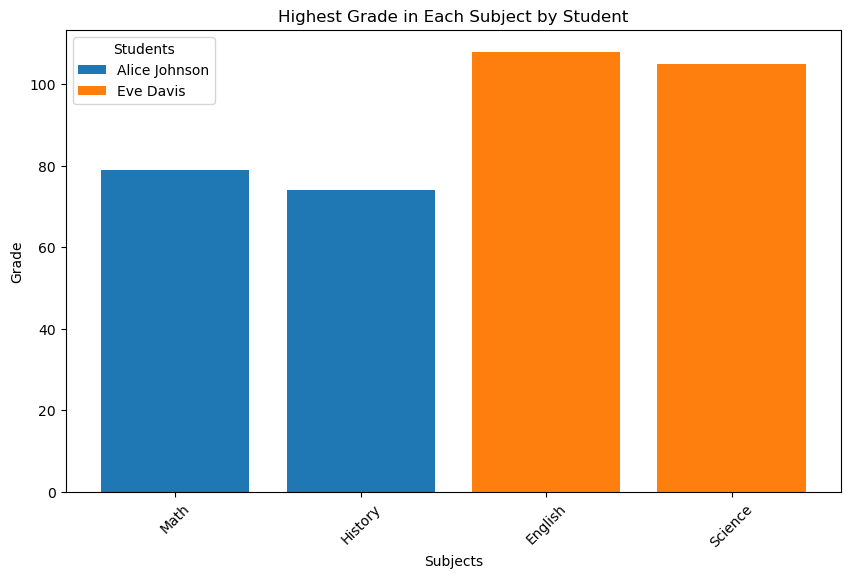

In [11]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Step 1
connection = sqlite3.connect('student_grades.db')
cursor = connection.cursor()

# Step 2
create_students_table = """
CREATE TABLE IF NOT EXISTS students (
    student_id INTEGER PRIMARY KEY AUTOINCREMENT,
    first_name TEXT,
    last_name TEXT
);
"""

create_grades_table = """
CREATE TABLE IF NOT EXISTS grades (
    grade_id INTEGER PRIMARY KEY AUTOINCREMENT,
    student_id INTEGER,
    subject TEXT,
    grade INTEGER,
    FOREIGN KEY (student_id) REFERENCES students(student_id)
);
"""

cursor.execute(create_students_table)
cursor.execute(create_grades_table)
connection.commit()


cursor.execute("DELETE FROM students")
cursor.execute("DELETE FROM grades")
connection.commit()

# Step 3
students_data = [
    ('Alice', 'Johnson'),
    ('Bob', 'Smith'),
    ('Carol', 'White'),
    ('David', 'Brown'),
    ('Eve', 'Davis')
]

insert_students_query = "INSERT INTO students (first_name, last_name) VALUES (?, ?)"
cursor.executemany(insert_students_query, students_data)
connection.commit()


cursor.execute("SELECT student_id, first_name FROM students")
student_ids = cursor.fetchall()

grades_data = []
for student in student_ids:
    sid = student[0]
    grades_data.extend([
        (sid, 'Math', 95 - sid),        # Just to have different grades
        (sid, 'English', 88 + sid),
        (sid, 'History', 90 - sid),
        (sid, 'Science', 85 + sid)
    ])

insert_grades_query = "INSERT INTO grades (student_id, subject, grade) VALUES (?, ?, ?)"
cursor.executemany(insert_grades_query, grades_data)
connection.commit()

# Step 4
# 1. Retrieve all students' names and their grades
query_1 = """
SELECT students.first_name, students.last_name, grades.subject, grades.grade
FROM students
JOIN grades ON students.student_id = grades.student_id;
"""
cursor.execute(query_1)
students_grades = cursor.fetchall()

# 2. Find the average grade for each student
query_2 = """
SELECT students.first_name, students.last_name, AVG(grades.grade) as average_grade
FROM students
JOIN grades ON students.student_id = grades.student_id
GROUP BY students.student_id;
"""
cursor.execute(query_2)
average_grade_per_student = cursor.fetchall()

# 3. Find the student with the highest average grade
query_3 = """
SELECT students.first_name, students.last_name, AVG(grades.grade) as average_grade
FROM students
JOIN grades ON students.student_id = grades.student_id
GROUP BY students.student_id
ORDER BY average_grade DESC
LIMIT 1;
"""
cursor.execute(query_3)
highest_avg_student = cursor.fetchone()

# 4. Find the average grade for the Math subject
query_4 = """
SELECT AVG(grade) as average_math_grade
FROM grades
WHERE subject = 'Math';
"""
cursor.execute(query_4)
average_math_grade = cursor.fetchone()

# 5. List all students who scored above 90 in any subject
query_5 = """
SELECT students.first_name, students.last_name, grades.subject, grades.grade
FROM students
JOIN grades ON students.student_id = grades.student_id
WHERE grades.grade > 90;
"""
cursor.execute(query_5)
students_above_90 = cursor.fetchall()

# Step 5
students_df = pd.read_sql_query("SELECT * FROM students", connection)
grades_df = pd.read_sql_query("SELECT * FROM grades", connection)

combined_query = """
SELECT students.first_name, students.last_name, grades.subject, grades.grade
FROM students
JOIN grades ON students.student_id = grades.student_id;
"""
combined_df = pd.read_sql_query(combined_query, connection)

print("Combined Students and Grades Data")
print(combined_df)


# Plot the average grades for each student
average_grades_df = pd.DataFrame(average_grade_per_student, columns=['first_name', 'last_name', 'average_grade'])
average_grades_df['full_name'] = average_grades_df['first_name'] + ' ' + average_grades_df['last_name']

plt.figure(figsize=(10, 6))
plt.bar(average_grades_df['full_name'], average_grades_df['average_grade'])
plt.xlabel('Students')
plt.ylabel('Average Grade')
plt.title('Average Grades for Each Student')
plt.xticks(rotation=45)
plt.show()

# Create a bar chart showing the average grade for each subject
average_subject_grades_df = combined_df.groupby('subject')['grade'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(average_subject_grades_df['subject'], average_subject_grades_df['grade'])
plt.xlabel('Subjects')
plt.ylabel('Average Grade')
plt.title('Average Grade for Each Subject')
plt.xticks(rotation=45)
plt.show()

# Display SQL query results in the console
{
    "All students' names and grades": students_grades,
    "Average grade for each student": average_grade_per_student,
    "Student with the highest average grade": highest_avg_student,
    "Average grade for Math subject": average_math_grade,
    "Students who scored above 90": students_above_90
}
# BONUS
query_bonus = """
SELECT students.first_name, students.last_name, grades.subject, grades.grade
FROM students
JOIN grades ON students.student_id = grades.student_id
WHERE (grades.subject, grades.grade) IN (
    SELECT subject, MAX(grade)
    FROM grades
    GROUP BY subject
);
"""
cursor.execute(query_bonus)
highest_grade_per_subject = cursor.fetchall()

# Display results for the bonus query
print("Student with the highest grade in each subject:")
for row in highest_grade_per_subject:
    print(f"{row[0]} {row[1]} - {row[2]}: {row[3]}")

# Step 2: Visualize the results using a grouped bar chart

# Convert the results into a DataFrame for visualization
highest_grade_df = pd.DataFrame(highest_grade_per_subject, columns=['first_name', 'last_name', 'subject', 'grade'])
highest_grade_df['full_name'] = highest_grade_df['first_name'] + ' ' + highest_grade_df['last_name']

# Plotting the grouped bar chart
plt.figure(figsize=(10, 6))
for name in highest_grade_df['full_name'].unique():
    student_data = highest_grade_df[highest_grade_df['full_name'] == name]
    plt.bar(student_data['subject'], student_data['grade'], label=name)

plt.xlabel('Subjects')
plt.ylabel('Grade')
plt.title('Highest Grade in Each Subject by Student')
plt.legend(title='Students')
plt.xticks(rotation=45)
plt.show()


# Close the database connection
connection.close()


In [5]:

print("All students' names and their grades:")
for row in students_grades:
    print(f"{row[0]} {row[1]} - {row[2]}: {row[3]}")
print("\n")

print("Average grade for each student:")
for row in average_grade_per_student:
    print(f"{row[0]} {row[1]}: {row[2]:.2f}")
print("\n")

print("Student with the highest average grade:")
if highest_avg_student:
    print(f"{highest_avg_student[0]} {highest_avg_student[1]}: {highest_avg_student[2]:.2f}")
else:
    print("No data available.")
print("\n")

print("Average grade for Math subject:")
if average_math_grade:
    print(f"Average Math Grade: {average_math_grade[0]:.2f}")
else:
    print("No data available.")
print("\n")

print("Students who scored above 90 in any subject:")
if students_above_90:
    for row in students_above_90:
        print(f"{row[0]} {row[1]} - {row[2]}: {row[3]}")
else:
    print("No students scored above 90.")


All students' names and their grades:
Alice Johnson - Math: 89
Alice Johnson - English: 94
Alice Johnson - History: 84
Alice Johnson - Science: 91
Bob Smith - Math: 88
Bob Smith - English: 95
Bob Smith - History: 83
Bob Smith - Science: 92
Carol White - Math: 87
Carol White - English: 96
Carol White - History: 82
Carol White - Science: 93
David Brown - Math: 86
David Brown - English: 97
David Brown - History: 81
David Brown - Science: 94
Eve Davis - Math: 85
Eve Davis - English: 98
Eve Davis - History: 80
Eve Davis - Science: 95


Average grade for each student:
Alice Johnson: 89.50
Bob Smith: 89.50
Carol White: 89.50
David Brown: 89.50
Eve Davis: 89.50


Student with the highest average grade:
Eve Davis: 89.50


Average grade for Math subject:
Average Math Grade: 87.00


Students who scored above 90 in any subject:
Alice Johnson - English: 94
Alice Johnson - Science: 91
Bob Smith - English: 95
Bob Smith - Science: 92
Carol White - English: 96
Carol White - Science: 93
David Brown - En